In [1]:
from train import train_epochs
from gan_sn import Generator, Discriminator
from src.wasserstein import generator_w_loss, critic_w_loss
from utils.hist import HistogramExperiment
import utils.pytorch_utils as ptu
from utils.utils import savefig, experiment_save_results
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
from torch.optim.lr_scheduler import StepLR
from scipy import stats, integrate
import time
import pandas as pd

In [2]:
g = {}
c = {}
delta = {}

In [3]:
config = {
    "batch_size": 64,
    "n_epochs": 50,
    "n_cr": 2,
    "c_lr": 9e-5,
    "c_betas": (0, 0.9),
    "c_params": (1, 3, 25, 1),
    "c_loss": critic_w_loss,
    "g_lr": 9e-5,
    "g_betas": (0, 0.9),
    "g_params": (3, 3, 25, 1),
    "g_loss": generator_w_loss,
    "exp_name": f"sn_ncr2",
    "dataset_params": [(2, 0.4),(0, 0.55),(5, 0.25)],
}

In [4]:
hist = HistogramExperiment(**config)

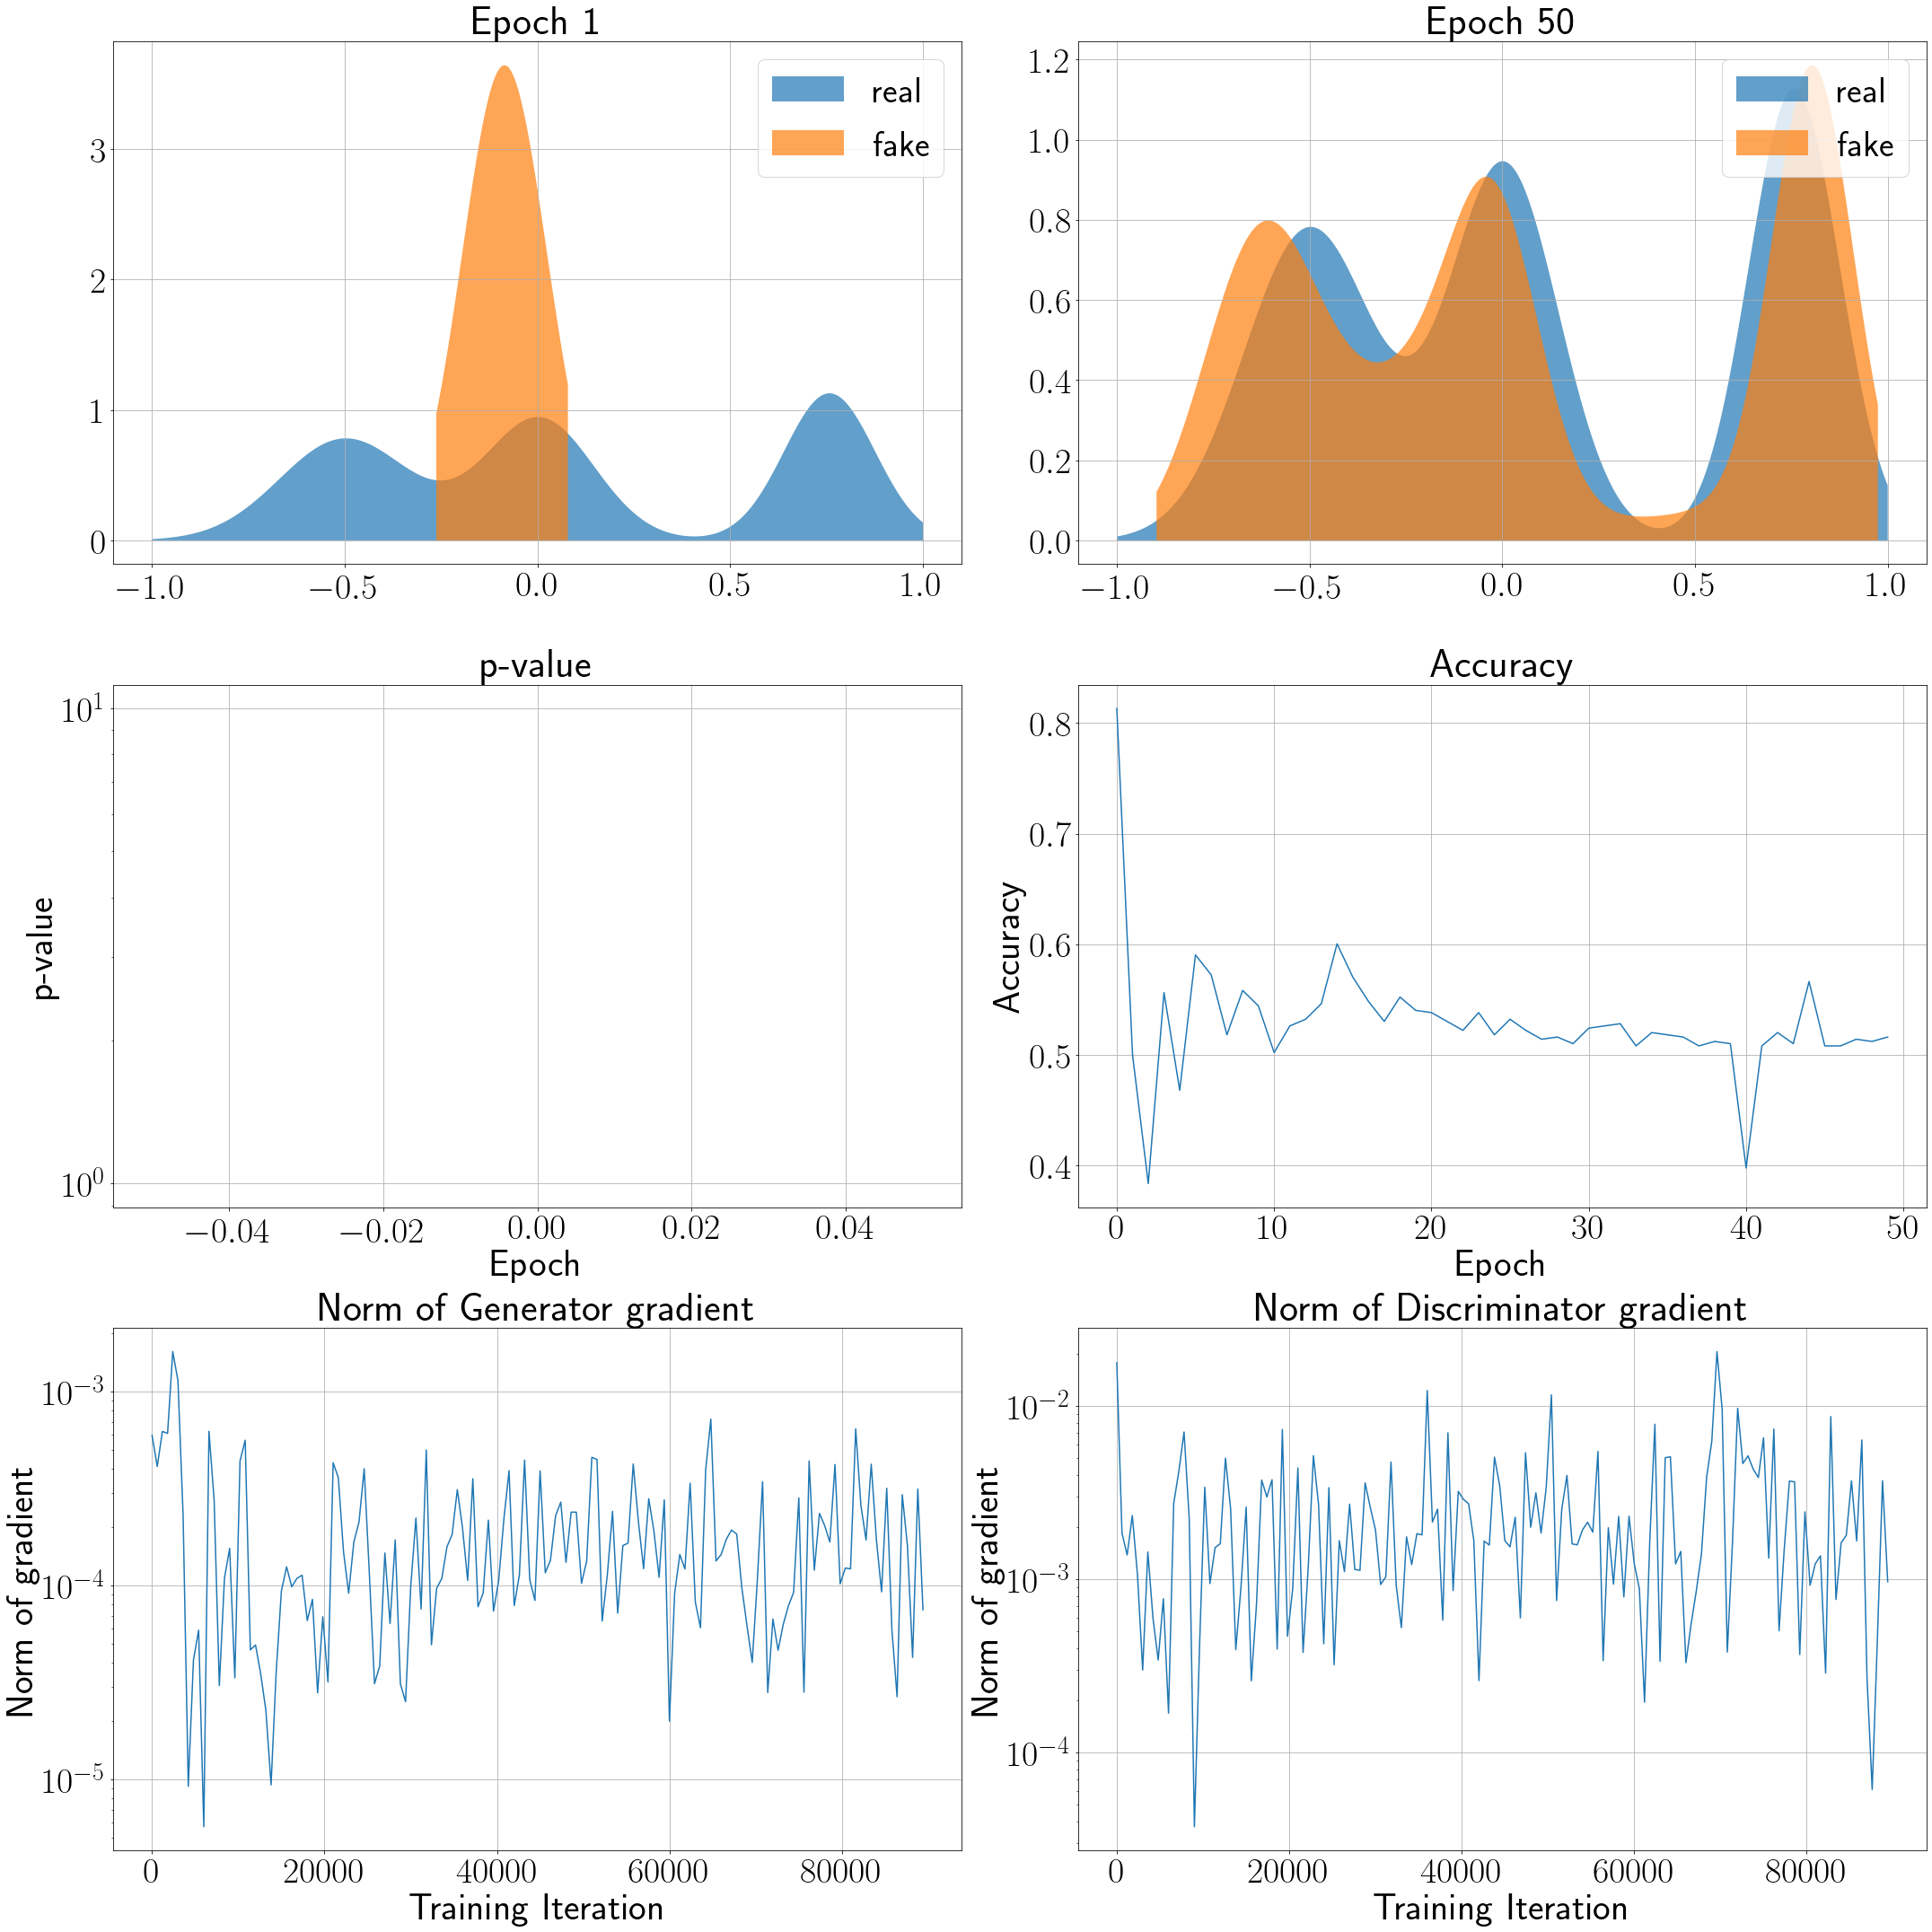

In [5]:
for n_cr in [2]:
    config["n_cr"] = n_cr
    config["exp_name"] = f"sn_ncr{n_cr}"
    start = time.time()
    g[n_cr], c[n_cr], train_losses = experiment_save_results(hist)
    end = time.time()
    delta[n_cr] = end-start
    np.save(f"results/sn_ncr{n_cr}/p", train_losses["pvals"])
    np.save(f"results/sn_ncr{n_cr}/c_grad", train_losses["c_grad"])
    np.save(f"results/sn_ncr{n_cr}/g_grad", train_losses["g_grad"])
    

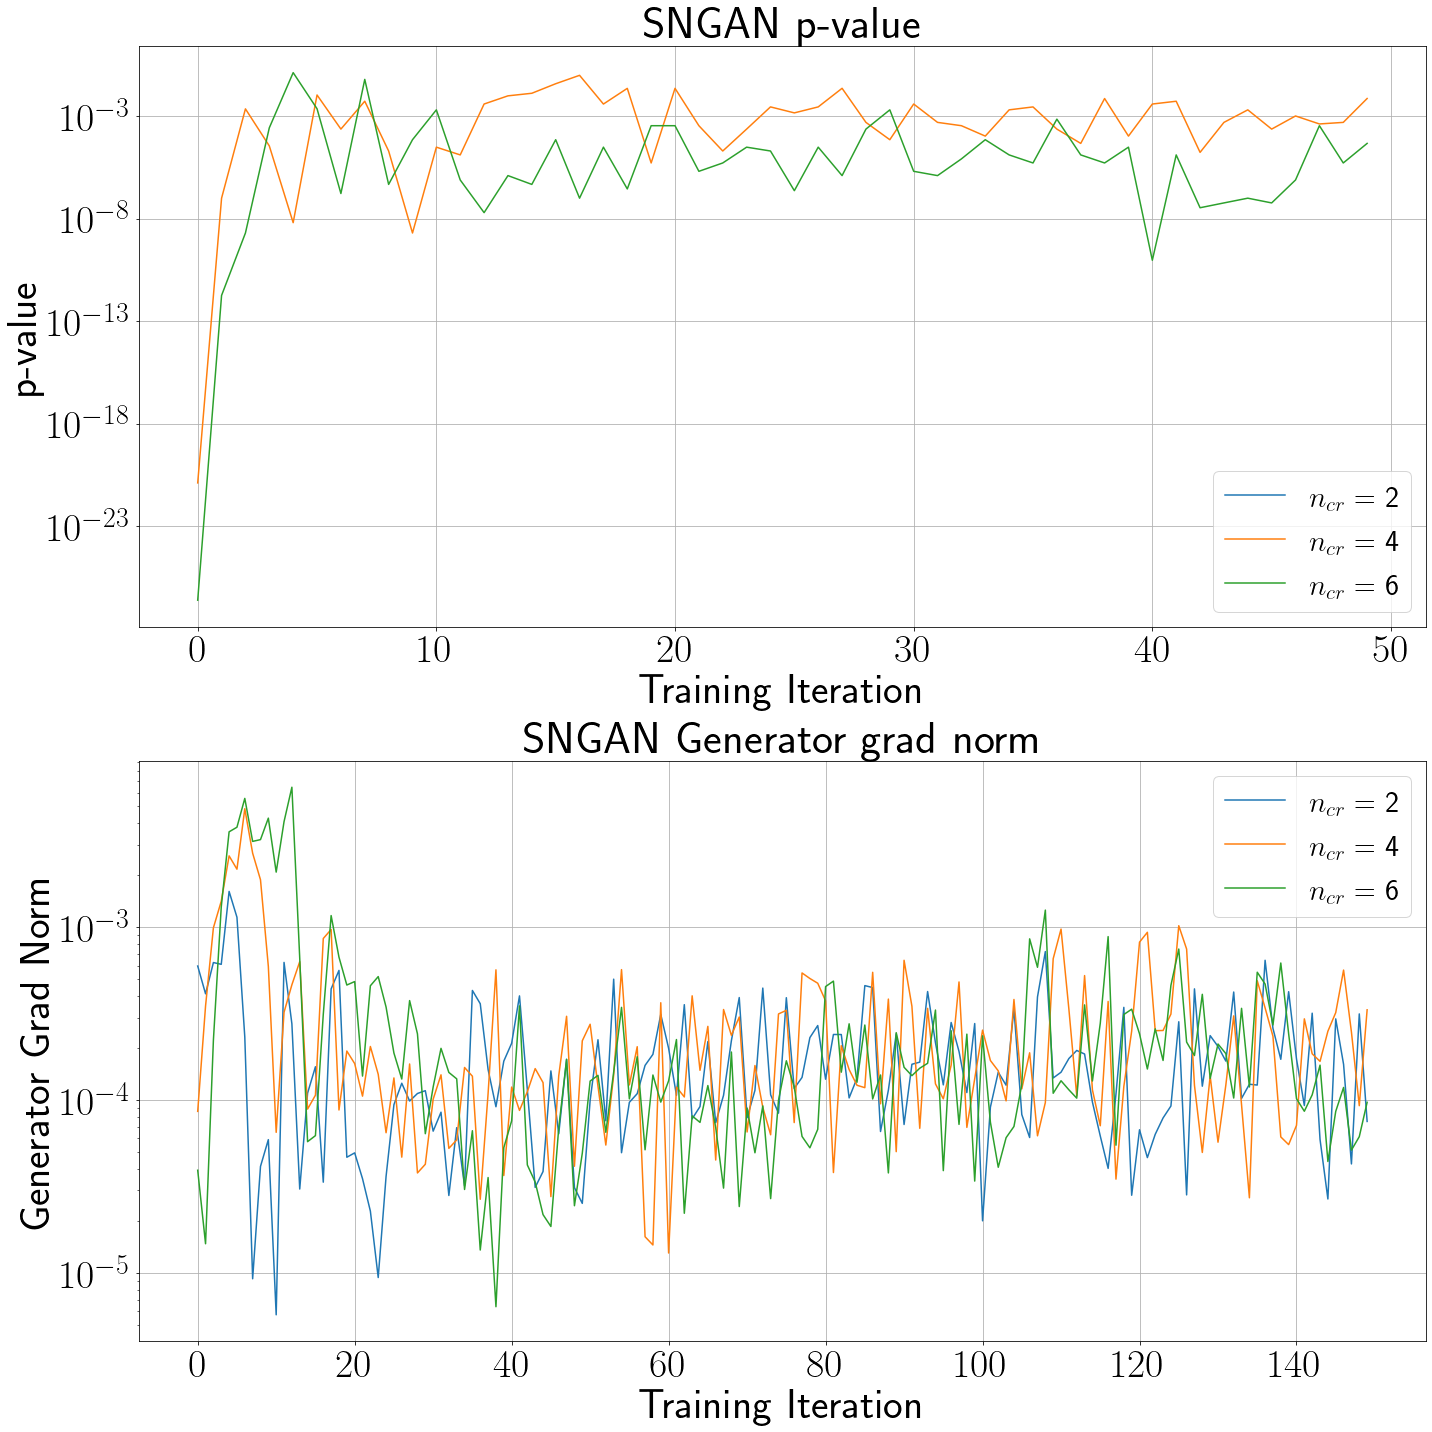

In [6]:
from utils.utils import compare_pvals, sn2nosn
compare_pvals()

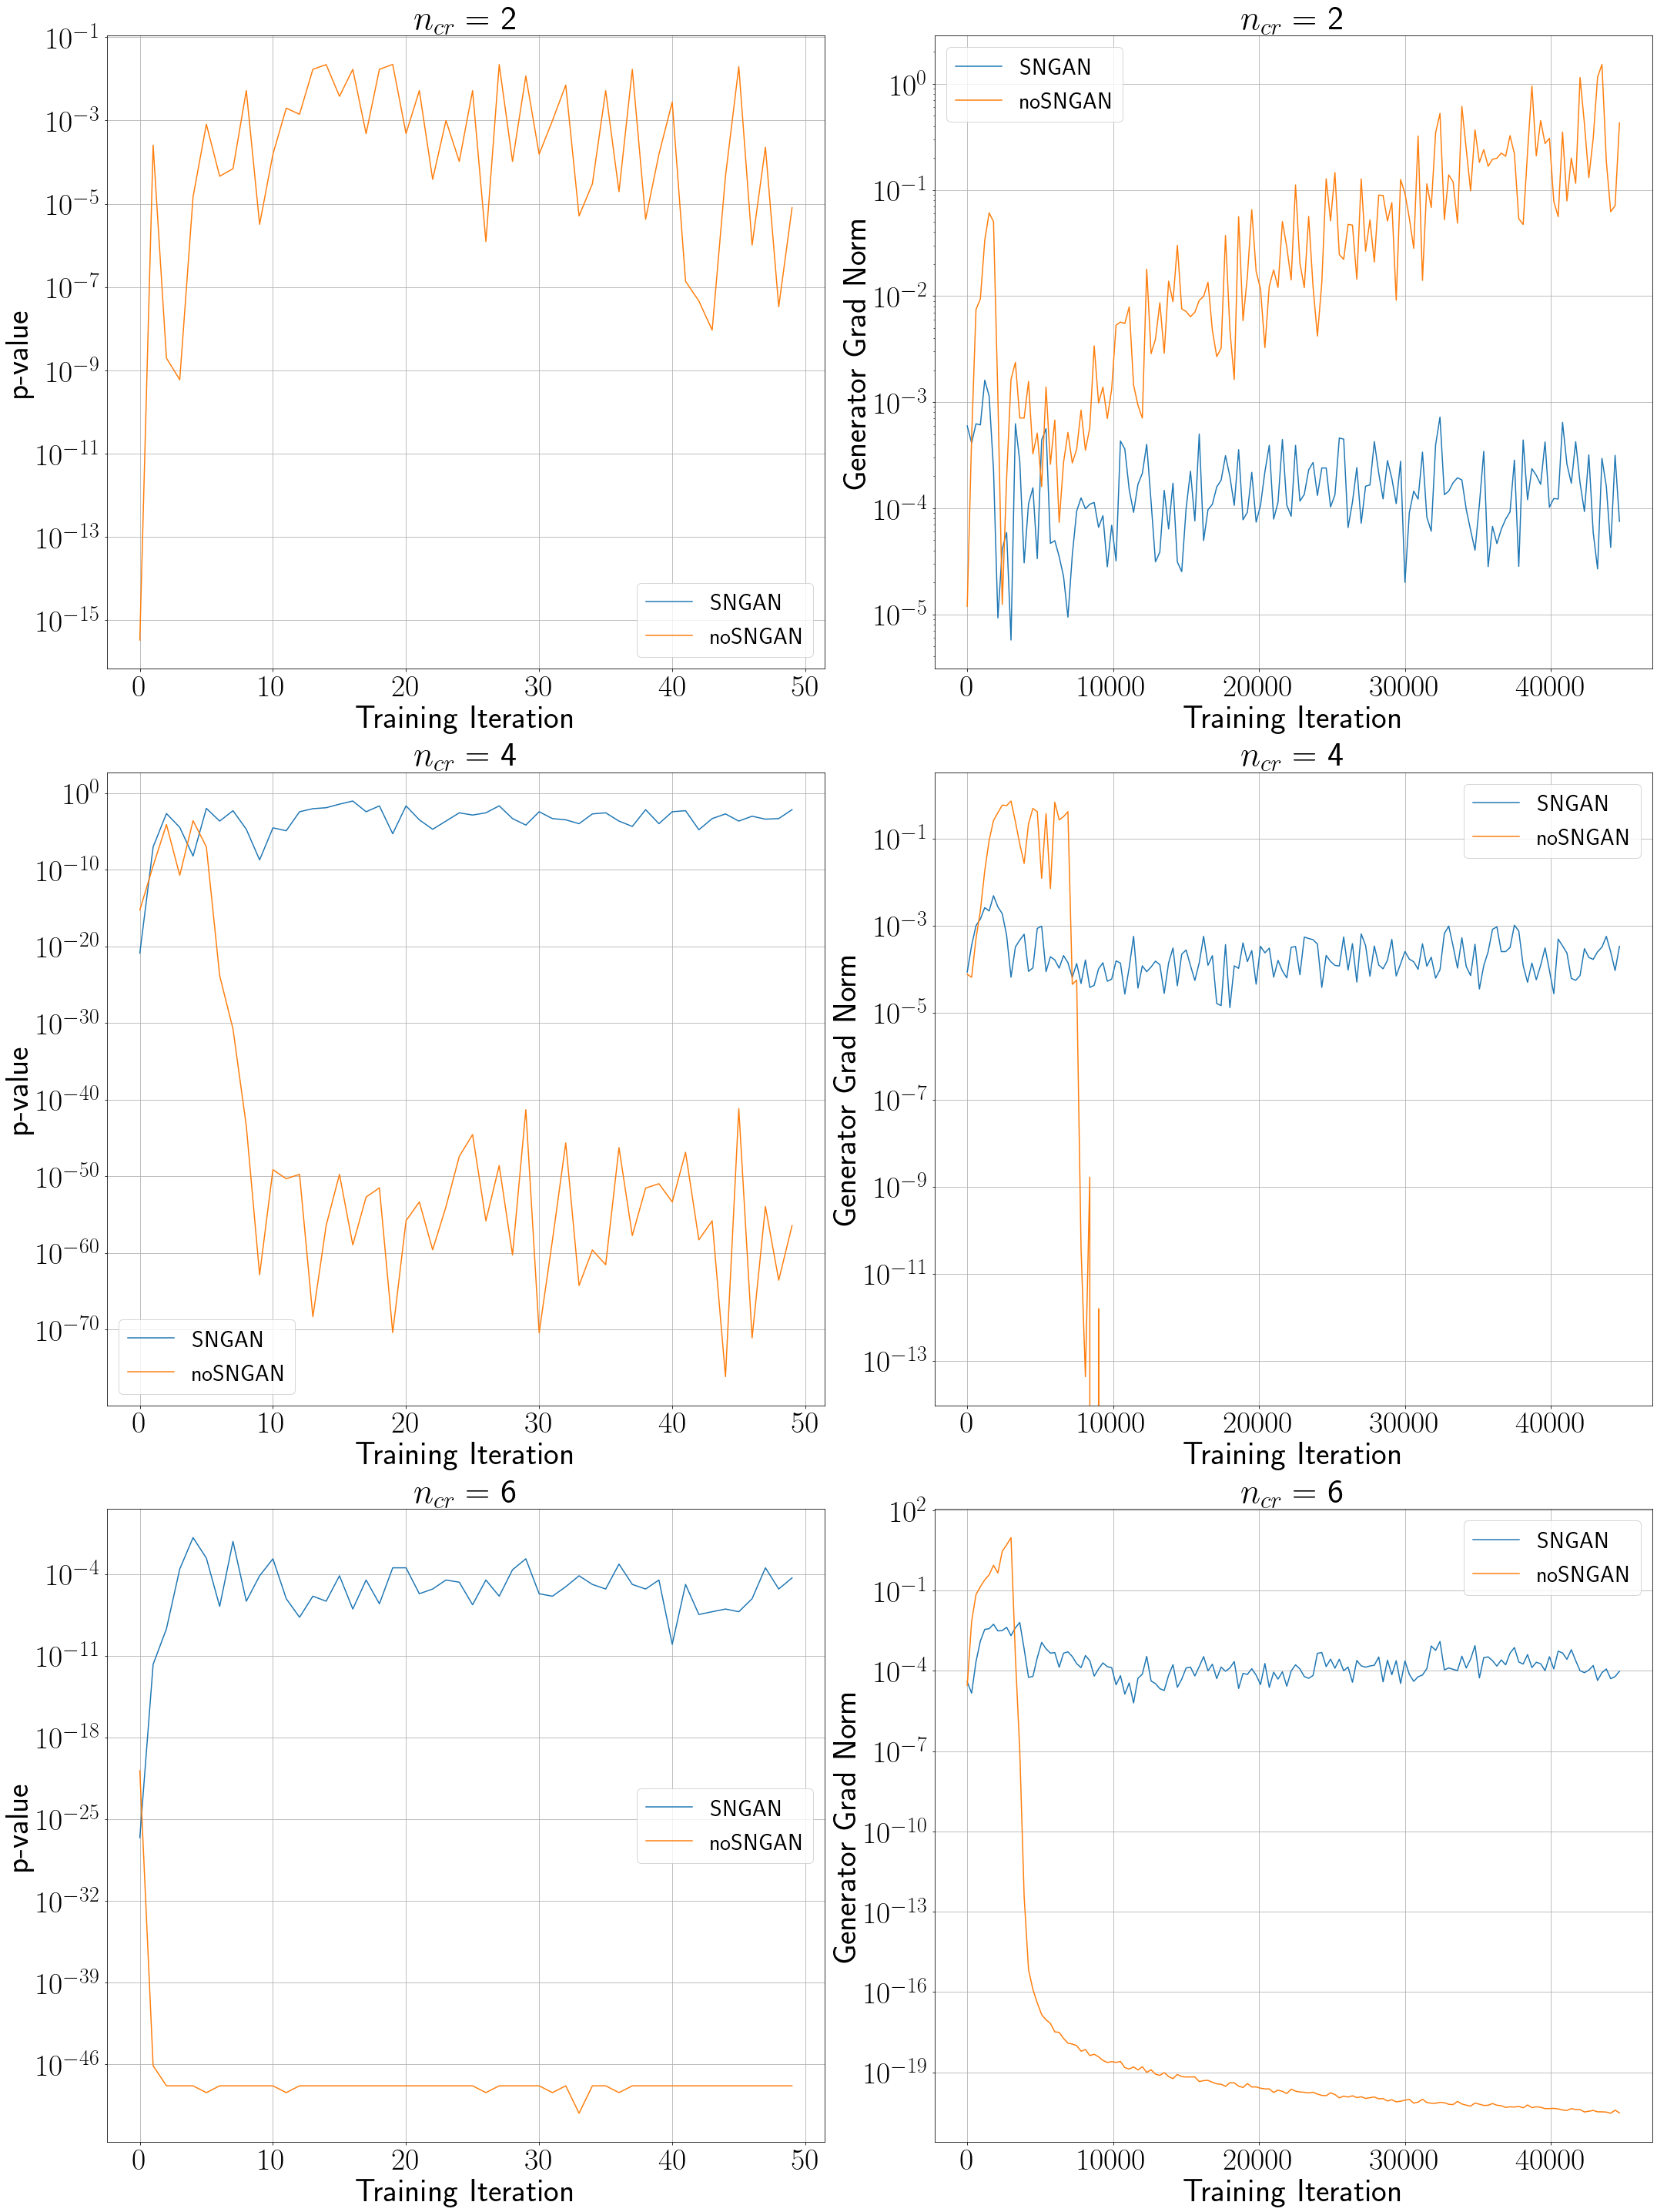

In [7]:
sn2nosn()

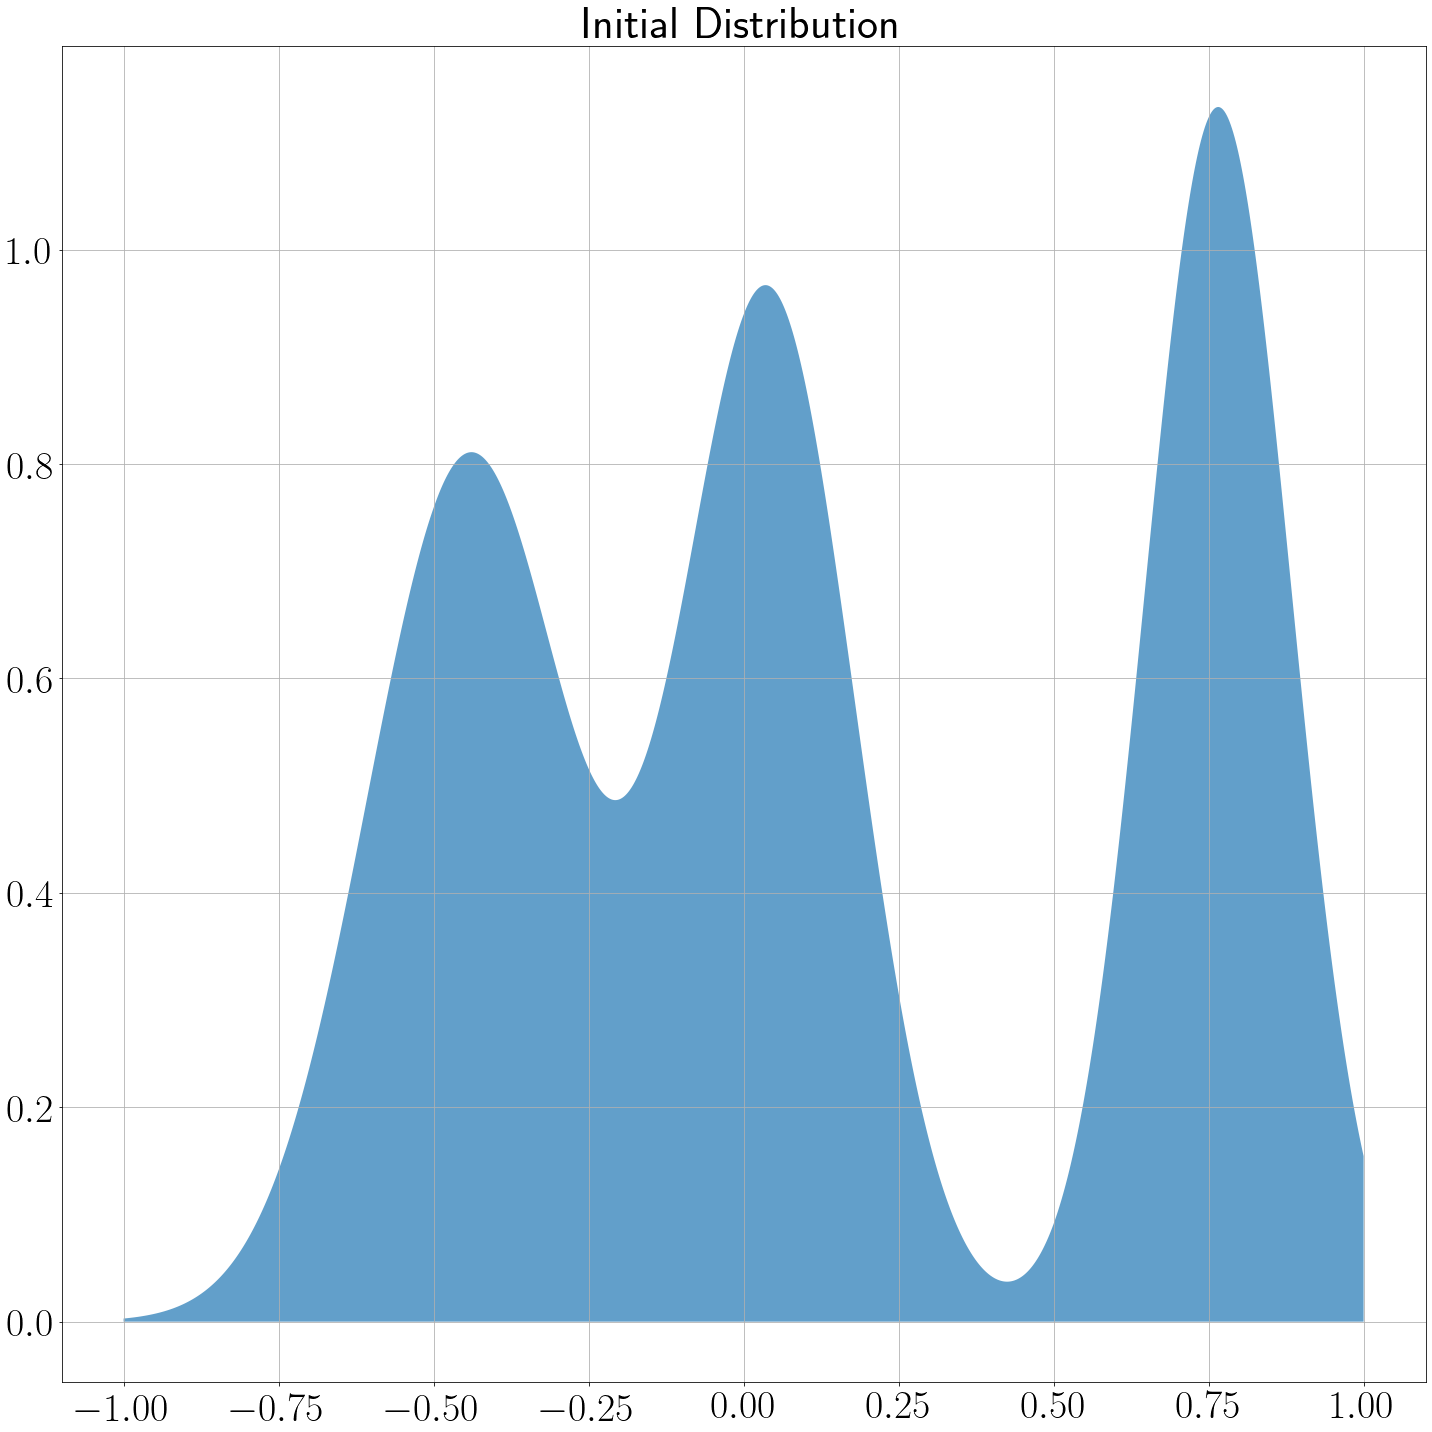

In [5]:
visualize_experiment_dataset(is_spiral=False, modes=n_modes, param_modes=params)

In [47]:
delta

{2: 234.82655310630798, 4: 209.77042508125305, 6: 205.16864585876465}

> Формула для спирали $r(\theta) = a+b\theta$

In [ ]:
a = experiment_data(n=1, is_spiral=True, n_modes=3, params=params)

In [ ]:
visualize_experiment_dataset(is_spiral=True)

In [ ]:
def exp2(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    
    g = Generator(10, 7, 50, 2).to(ptu.device)
    c = Discriminator(2, 4, 30, 1).to(ptu.device)


    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        batch_size = x.shape[0]
        fake_data = generator.sample(batch_size)
        return critic(fake_data).mean() - critic(x).mean() #- 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 500

    c_opt = optim.Adam(c.parameters(), lr=9e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=9e-5, betas=(0.5, 0.9))
#     c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=250, gamma=0.8)
#     g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=200, gamma=0.9)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 5, 
        "final_snapshot":True
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=True, name="spiralsncr2")
    train_losses, samples_1, samples_final = result
    return g, c, train_losses['c_losses'], samples_1, samples_final

In [ ]:
start = time.time()
g, c, *_ = experiment_save_results('a', exp2, 'spiral', is_spiral=True)
end = time.time()
delta.append(end-start)